# Importing Important Libraries

In [210]:
import numpy as np
import pandas as pd
import gurobipy as gp
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Loading the dataset

In [2]:
train_df = pd.read_csv('training_data.csv')
test_df = pd.read_csv('test_data.csv')

In [3]:
train_df.head()

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.536145,-1.535413,0.718888,-2.099149,-0.442842,-0.598978,-1.642574,0.207755,0.760642,0.575874,...,0.361866,1.793098,-0.631287,-0.061751,0.511049,0.488754,-0.612772,-0.471045,-1.139781,-0.260773
1,4.808344,-1.734609,0.551981,-2.147673,-1.552944,1.514910,-1.143972,0.737594,1.321243,-0.261684,...,-0.677985,-0.165679,0.065405,0.137162,1.258197,-0.120834,-1.564834,-0.242565,-0.001827,1.187453
2,-1.530427,0.097257,0.107634,-0.194222,0.335454,-0.408199,0.133265,0.706179,0.394971,-0.437116,...,1.108801,0.333791,0.282055,-1.086294,-0.115354,0.257857,-0.088838,-0.751231,1.450609,0.290593
3,-0.428243,-0.067702,0.557836,0.700848,-1.121376,1.722274,0.613525,0.700909,-0.417976,1.069749,...,0.692511,-0.350990,0.624558,0.434520,-0.367409,-1.144681,-0.136524,-0.557214,0.416303,0.484495
4,0.566694,0.488729,0.211483,0.568389,0.646837,0.163868,-0.002152,0.125137,0.493571,1.705451,...,-0.000605,1.075280,0.182281,-1.138458,0.106092,0.544640,-0.383487,-0.425773,2.667647,-0.050748


In [4]:
#Splitting data into X(Independent Variables) and Y(Independent variables)

y = train_df['y']
x = train_df.drop(columns=['y'])

In [5]:
# Saving the number of rows and columns
nrows = x.shape[0]
ncols = x.shape[1]


# Defining the number of folds = 10
num_folds = 10


# Determine the fold size
fold_size = nrows // num_folds


In [6]:
#checking for fold size

fold_size

25

In [8]:
# Keeping the time limit to 1

time_limit = 1

In [9]:
# Creating all the values ranging from 5 to 50
k_list = [i+5 for i in range(0,ncols,5)]

# setting the variable to be used by the gurobi
M = 500 
M_negative = -M
row_per_fold = nrows//num_folds
k_error_vals = {}


# starting to iterate over values of K in K_list
for k in k_list:
    total_sse = 0
    total_sse_val = 0
    
    # iterating over all the 10 folds
    
    for _ in range(num_folds):
        
        # creating shuffled index using np.random.choice() function 
        
        val_index = np.random.choice(len(x), size=int(len(x) / num_folds), replace=False)
        train_index = np.setdiff1d(np.arange(len(x)), val_index)
        
        # creating the X_train and X_Val for the K-folds using the index created post shuffling
        
        X_train_fold, X_val_fold = x.iloc[train_index,:], x.iloc[val_index,:]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Initializing the Gurobi Model
        
        qp = gp.Model()
        
        # Defining the number of variables, setting the objecting function and defining the constraints
        beta = qp.addMVar(ncols+1,lb=-np.inf)
        z = qp.addMVar(ncols, vtype = 'B')
        qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(ncols)) - y_train_fold.iloc[i]) 
                                    * (beta[0] + gp.quicksum(beta[j+1]*X_train_fold.iloc[i][j] for j in range(ncols)) - y_train_fold.iloc[i])
                                     for i in range(len(X_train_fold))))

        con1 = qp.addConstr(gp.quicksum(z[j] for j in range(ncols)) <= k )
        con2 = qp.addConstrs(beta[j+1] <= M*z[j] for j in range(ncols))
        con3 = qp.addConstrs(beta[j+1] >= M_negative*z[j] for j in range(ncols))

        qp.Params.OutputFlag = 0
        
        # setting the time limit
        qp.setParam('TimeLimit', time_limit)
        qp.optimize()
        
        # Calculating the validation error using the beta values

        val_error_sse = 0
        opt_beta = list(beta.x)
        
        for i in range(len(X_val_fold)):
            wi_value = 0
            for j in range(ncols):
                wi_value += opt_beta[j + 1] * X_val_fold.iloc[i, j]
    
            val_error_sse += ((opt_beta[0] + wi_value) - y_val_fold.iloc[i])*((opt_beta[0] + wi_value) - y_val_fold.iloc[i])
        print(f"Error in Valdiation set = {val_error_val}")
        
        # storing the validation error across all the folds of data
        total_sse_val += val_error_sse
        
        
    print("*"*50)
    print(f"SSE on validation set for k = {k} is {total_sse_val/num_folds}") 
    print("*"*50)
    k_error_vals[k] = total_sse_val/num_folds

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-20
Error in Valdiation set = 68.37268607874469
Error in Valdiation set = 77.7963734585916
Error in Valdiation set = 104.33976692895855
Error in Valdiation set = 76.29484671721038
Error in Valdiation set = 167.34763672161307
Error in Valdiation set = 96.94370057913781
Error in Valdiation set = 97.56118799076474
Error in Valdiation set = 123.1875919022196
Error in Valdiation set = 71.33167986226296
Error in Valdiation set = 121.84348535945858
**************************************************
SSE on validation set for k = 5 is 100.50189555989621
**************************************************
Error in Valdiation set = 43.11494640046104
Error in Valdiation set = 60.31942911298254
Error in Valdiation set = 77.58958676711413
Error in Valdiation set = 72.59787921218572
Error in Valdiation set = 59.76194105608731
Error in Valdiation set = 70.46582186718433
Error in Valdiation set = 63.49384032810583
Err

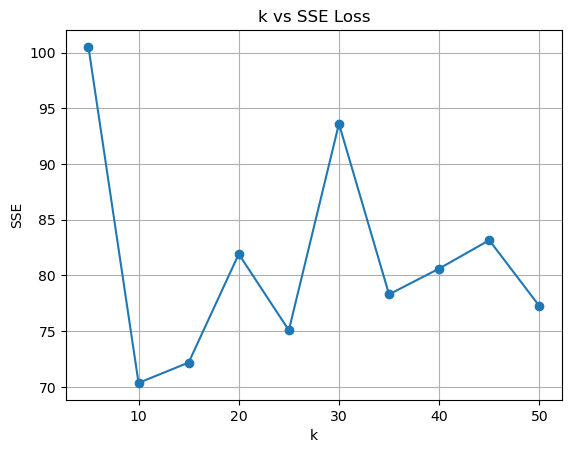

In [10]:
k_vals = list(k_error_vals.keys())
loss_vals = list(k_error_vals.values())

# Plotting
plt.plot(k_vals, loss_vals, marker='o', linestyle='-')
plt.title('k vs SSE Loss')
plt.xlabel('k')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

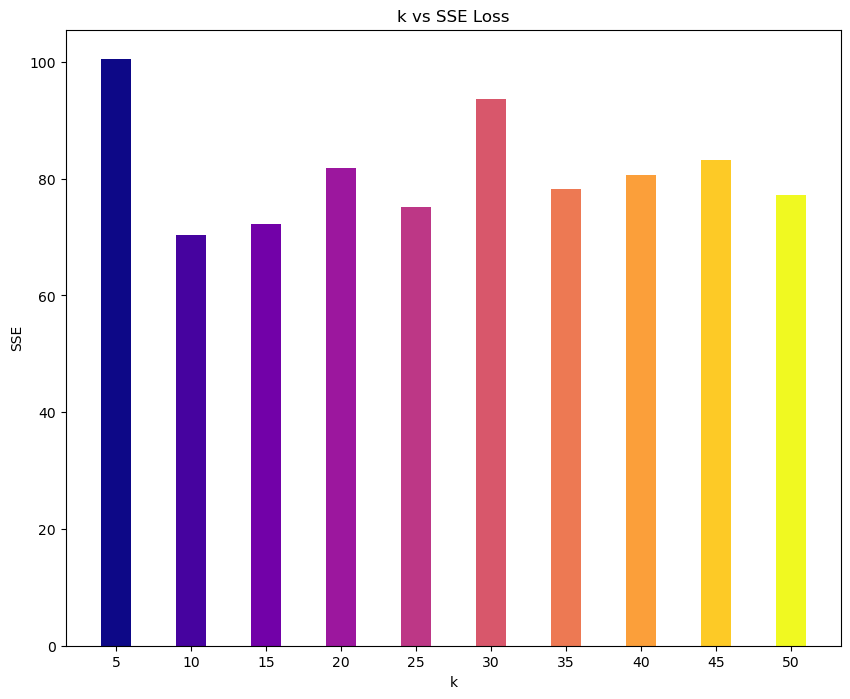

In [20]:


k_vals = list(k_error_vals.keys())
loss_vals = list(k_error_vals.values())


# Choosing a different color map for better colors
colors = plt.cm.plasma(np.linspace(0, 1, len(k_vals)))

# Plotting as a bar plot with increased bar width, different colors, and no gridlines
plt.figure(figsize=(10, 8))
bars = plt.bar(k_vals, loss_vals, width=2, color=colors)  # Adjust the width as needed
plt.title('k vs SSE Loss')
plt.xlabel('k')
plt.ylabel('SSE')
plt.xticks(np.arange(5, 55, 5))  # Set the x-axis ticks from 5 to 50 with an increment of 5
plt.grid(False)  # Remove gridlines


plt.show()

In [40]:
data = {
    'K_Value': k_vals,
    'Error_Value': loss_vals
}

miqp_error = pd.DataFrame(data)

miqp_error

,K_Value,Error_Value
0,5,100.501896
1,10,70.349769
2,15,72.179338
3,20,81.913364
4,25,75.077303
5,30,93.607441
6,35,78.298170
7,40,80.609670
8,45,83.159694
9,50,77.249424


In [21]:
min_k = min(k_error_vals, key=lambda k: k_error_vals[k])
min_k

10

In [22]:
#creating test and train data

Y_train = train_df['y']
X_train = train_df.drop(columns=['y'])

Y_test = test_df['y']
X_test = test_df.drop(columns=['y'])

In [218]:
M=500
M_negative = -M


start_time = time.time()
qp = gp.Model()
beta = qp.addMVar(ncols+1,lb=-np.inf)
z = qp.addMVar(ncols, vtype = 'B')
qp.setObjective(gp.quicksum((beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(ncols)) - Y_train.iloc[i]) 
                            * (beta[0] + gp.quicksum(beta[j+1]*X_train.iloc[i][j] for j in range(ncols)) - Y_train.iloc[i])
                            for i in range(len(X_train))))

con1 = qp.addConstr(gp.quicksum(z[j] for j in range(ncols)) <= min_k )
con2 = qp.addConstrs(beta[j+1] <= M*z[j] for j in range(ncols))
con3 = qp.addConstrs(beta[j+1] >= M_negative*z[j] for j in range(ncols))

qp.Params.OutputFlag = 0
qp.setParam('TimeLimit', time_limit)
qp.optimize()

opt_beta = list(beta.x)

y_pred_miqp = []
val_error = 0
for i in range(len(X_test)):
    inner_sum = 0
    for j in range(ncols):
        inner_sum += opt_beta[j + 1] * X_test.iloc[i, j]
    pred = inner_sum + opt_beta[0]
    y_pred_miqp.append(pred)
    val_error += (Y_test.iloc[i] - (opt_beta[0] + inner_sum))*(Y_test.iloc[i] - (opt_beta[0] + inner_sum))
    

        
end_time = time.time()

print(f"SSE on test set for k = {min_k} is {val_error}") 
# Calculate the runtime
runtime = end_time - start_time
print(f"Model runtime: {runtime} seconds")

SSE on test set for k = 10 is 116.82719822762621
Model runtime: 7.995396852493286 seconds


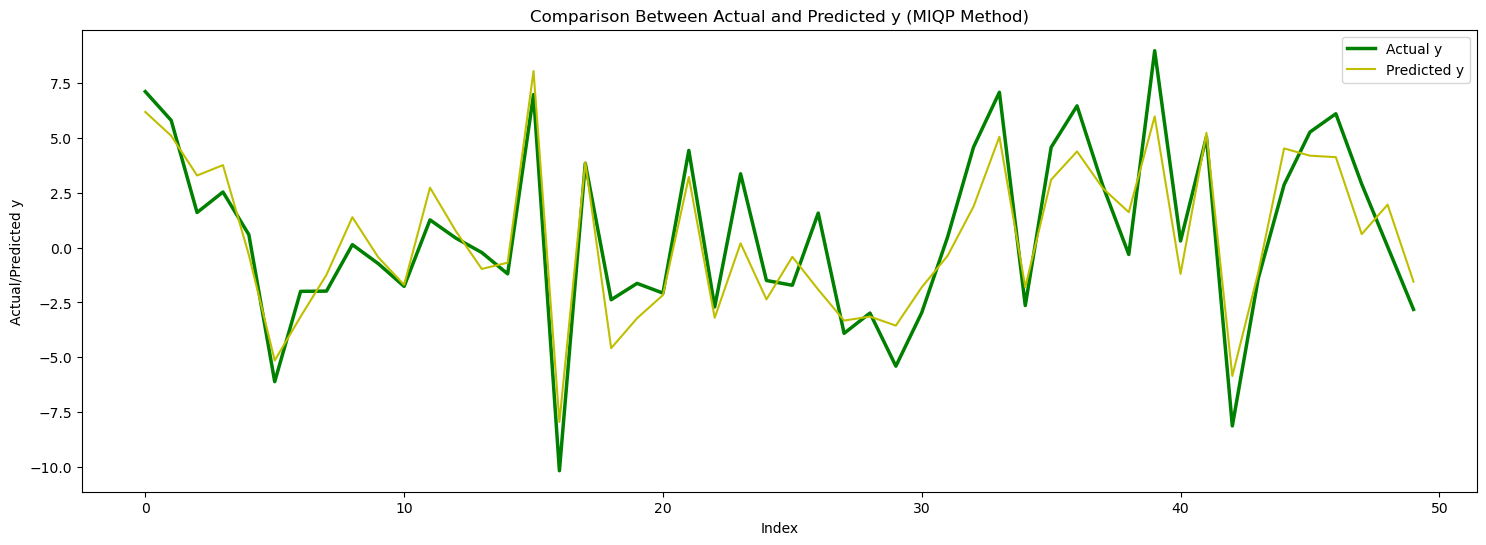

In [24]:
plt.figure(figsize=(18,6))
plt.plot(Y_test.index, Y_test, color='g', label='Actual y', linewidth=2.5)
plt.plot(Y_test.index, y_pred_miqp, color='y', label='Predicted y')
plt.xlabel('Index')
plt.ylabel('Actual/Predicted y')
plt.title('Comparison Between Actual and Predicted y (MIQP Method)')
plt.legend()
plt.show()

# Lasso Model

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

In [47]:
X_train = train_df.drop(columns='y')
y_train = train_df['y']

X_test = test_df.drop(columns='y')
y_test = test_df['y']

In [48]:
scaler = StandardScaler().fit(X_train) 

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [219]:
start_time = time.time()
model = LassoCV(cv = 10, random_state = 10, max_iter = 10000)
# Fit model
model.fit(X_train_sc, y_train)
model.alpha_

0.08471942409934509

In [220]:

# Get intercept and beta values
intercept_value = model.intercept_
beta_values = model.coef_

lasso_betas = []
lasso_betas.append(intercept_value)
lasso_betas = lasso_betas + (list(beta_values))



y_pred = model.predict(X_test_sc)
sse_test = np.sum((y_test - y_pred) ** 2)

end_time = time.time()
print(f"SSE on the test set: {sse_test}")

# Calculate the runtime
runtime = end_time - start_time
print(f"Model runtime: {runtime} seconds")

SSE on the test set: 117.83331916077931
Model runtime: 0.46189403533935547 seconds


In [216]:
pred_data = pd.DataFrame()
pred_data['y_test'] = y_test
pred_data['pred_test'] = y_pred
pred_data.sort_index(inplace = True)

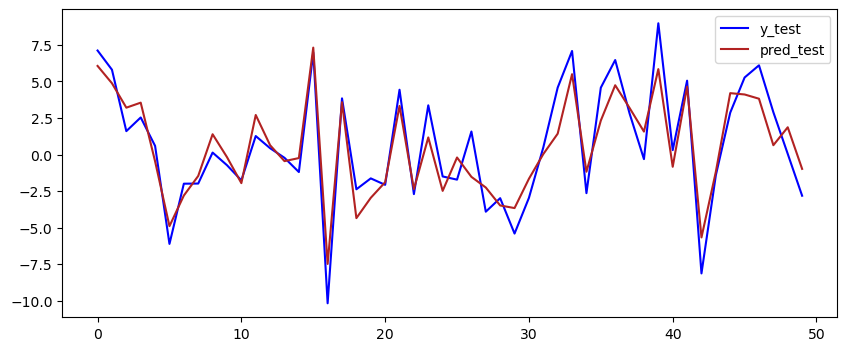

In [157]:
pred_data.plot(y=["y_test", "pred_test"],
        kind="line", figsize=(10, 4), color = ['blue', 'firebrick'])
 
# display plot
plt.show()

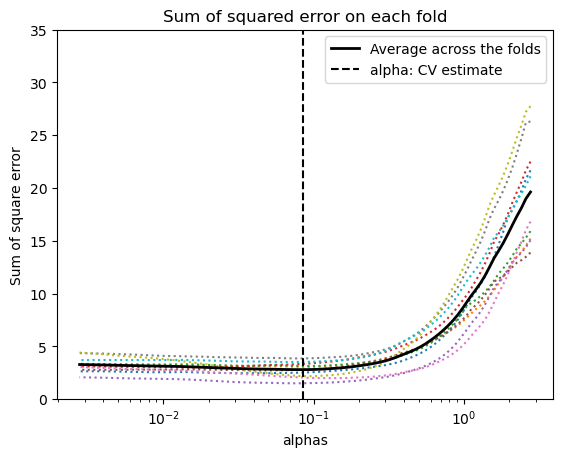

In [174]:
import matplotlib.pyplot as plt

plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Sum of square error")
plt.title("Sum of squared error on each fold")
plt.axis("tight")

ymin, ymax = 0, 35
plt.ylim(ymin, ymax);

# Appendix

In [202]:
values = ['Intercept']
# Generate values from x0 to x51
values += ['x' + str(i) for i in range(1,51)]

# Create a DataFrame with a single column
beta_comparsion = pd.DataFrame({'Variable': values})

In [203]:
beta_comparsion['MIQP_Betas'] = opt_beta
beta_comparsion['Lasso_Betas'] = lasso_betas

In [204]:
beta_comparsion

,Variable,MIQP_Betas,Lasso_Betas
0,Intercept,0.972524,1.276232
1,x1,0.000000,-0.000000
2,x2,0.000000,-0.000000
3,x3,0.000000,0.000000
4,x4,0.000000,0.000000
5,x5,0.000000,-0.000000
6,x6,0.000000,0.000000
7,x7,0.000000,-0.000000
8,x8,0.000000,-0.000000
9,x9,-2.308207,-2.719827


In [205]:
#beta_comparsion = beta_comparsion[(beta_comparsion.MIQP_Betas != 0) & (beta_comparsion.Lasso_Betas != 0)]

In [206]:
beta_comparsion

,Variable,MIQP_Betas,Lasso_Betas
0,Intercept,0.972524,1.276232
1,x1,0.000000,-0.000000
2,x2,0.000000,-0.000000
3,x3,0.000000,0.000000
4,x4,0.000000,0.000000
5,x5,0.000000,-0.000000
6,x6,0.000000,0.000000
7,x7,0.000000,-0.000000
8,x8,0.000000,-0.000000
9,x9,-2.308207,-2.719827


In [207]:
beta_comparsion.to_excel('beta_comparison_v1.xlsx')

In [132]:
error_comparsion = pd.DataFrame({'MIQP_Val_Error' : [val_error], 'Lasso_Val_Error':[sse_test] }).T.reset_index()

In [133]:
error_comparsion.columns = ['Error_Type', 'Error_Value']
error_comparsion

,Error_Type,Error_Value
0,MIQP_Val_Error,116.827198
1,Lasso_Val_Error,117.833319


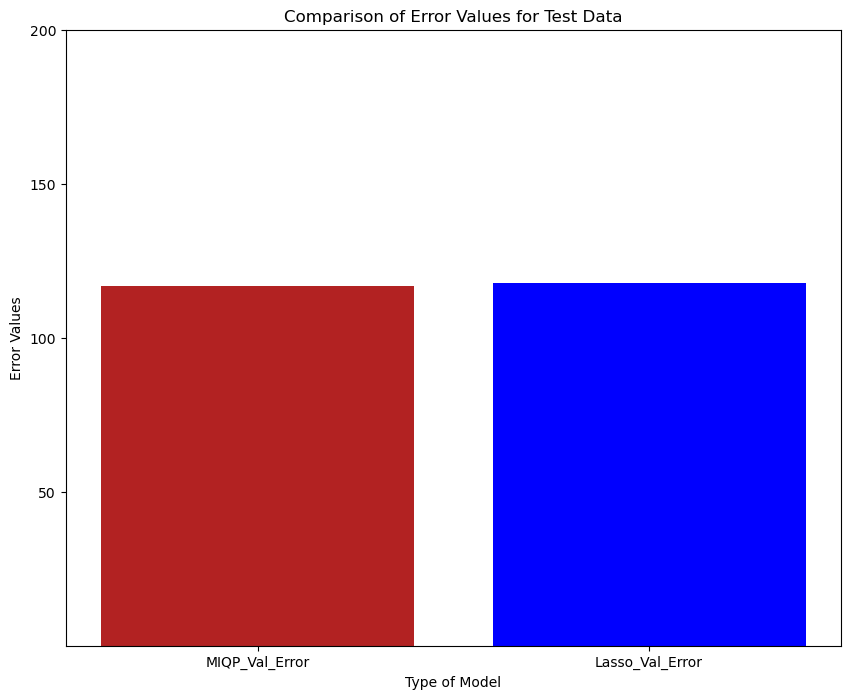

In [224]:
# Set up the figure size
plt.figure(figsize=(10, 8))

# Plotting bar chart
bars = plt.bar(data=error_comparsion, x='Error_Type', height='Error_Value', color=['firebrick', 'blue'])

# Customize y-axis ticks
plt.yticks(range(50, 201, 50))

plt.xlabel('Type of Model')
plt.ylabel('Error Values')
plt.title('Comparison of Error Values for Test Data')

# Show the plot
plt.show()
